#Detecção de Fraudes em Cartões de Crédito com XAI

**Data:** 17 de Maio de 2024

# Configuração e Análise Exploratória Inicial

### 1. Configuração do Ambiente

Nesta primeira etapa, vamos instalar e importar todas as bibliotecas que serão essenciais para o nosso projeto. A organização do ambiente é o primeiro passo para um projeto de dados bem-sucedido.



In [1]:
# Célula 1: Instalação de Bibliotecas
!pip install kaggle -q
!pip install xgboost -q
!pip install imbalanced-learn -q
!pip install shap -q

print("Bibliotecas instaladas com sucesso!")

Bibliotecas instaladas com sucesso!


### 2. Importação das Bibliotecas

Com o ambiente pronto, importamos os pacotes que utilizaremos. Cada biblioteca tem um papel fundamental:
- **Pandas e NumPy:** Para manipulação e operações com dados.
- **Matplotlib e Seaborn:** Para visualização e análise exploratória.
- **Scikit-learn:** Nosso canivete suíço para pré-processamento, modelagem e avaliação.
- **Imbalanced-learn:** Ferramenta específica para tratar o grande desafio deste projeto: o desbalanceamento dos dados.
- **XGBoost:** Nosso modelo de classificação, conhecido pela sua performance e robustez.
- **SHAP:** A biblioteca que nos permitirá explicar as decisões do nosso modelo de "caixa-preta".

In [2]:
# Célula 2: Importação
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Ferramentas de pré-processamento e modelagem
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Modelos e tratamento de desbalanceamento
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

# Configurações visuais
sns.set_style('darkgrid')
%matplotlib inline

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


### 3. Carregamento dos Dados

Para garantir a reprodutibilidade e a integridade do nosso projeto, vamos baixar os dados diretamente da fonte (Kaggle) utilizando sua API.

In [3]:
# Célula 3: Configuração da API do Kaggle e Download
from google.colab import files

# Faz o upload do arquivo kaggle.json
files.upload()

# Configura o diretório do Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixa o dataset e descompacta
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

print("Dataset baixado e descompactado com sucesso!")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.38GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          
Dataset baixado e descompactado com sucesso!


### 4. Análise Exploratória de Dados (EDA) - Parte 1: Estrutura dos Dados

Agora começa a ciência. Carregamos o dataset e realizamos uma análise inicial para entender com o que estamos lidando.
- Qual o formato dos dados?
- Existem valores nulos?
- Quais são os tipos de cada coluna?

In [4]:
# Célula 4: Carregando o CSV e inspeção inicial
df = pd.read_csv('creditcard.csv')

print("Formato do DataFrame:", df.shape)
print("\nPrimeiras 5 linhas:")
display(df.head())

print("\nInformações do DataFrame:")
df.info()

print("\nVerificação de valores nulos:")
print(df.isnull().sum().any()) # Retorna True se houver qualquer valor nulo

Formato do DataFrame: (284807, 31)

Primeiras 5 linhas:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-nu

#### EDA - Parte 2: O Grande Desafio - O Desbalanceamento

Aqui, visualizamos a distribuição da nossa variável alvo, `Class`. A proporção entre transações legítimas (0) e fraudulentas (1) é o principal desafio técnico deste projeto. Um modelo ingênuo que sempre previsse "não fraude" teria uma acurácia altíssima, mas seria completamente inútil.

Distribuição das Classes:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


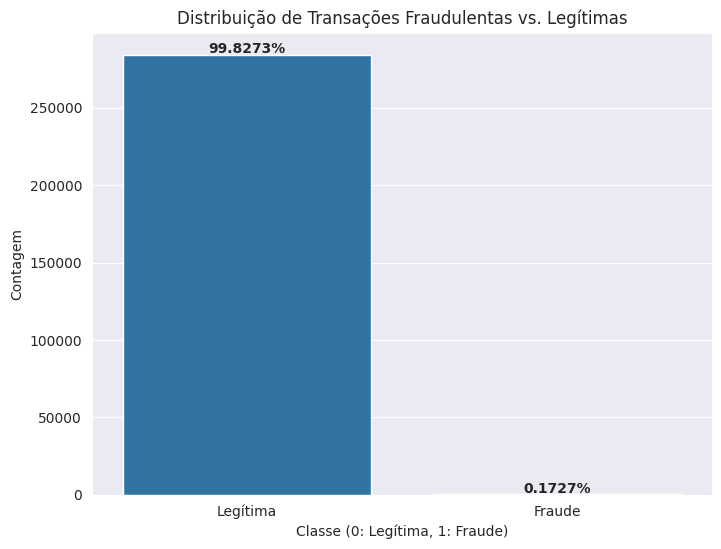

In [5]:
# Célula 5: Análise da variável alvo 'Class'
print("Distribuição das Classes:")
class_distribution = df['Class'].value_counts(normalize=True) * 100
print(class_distribution)

# Visualização da distribuição
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribuição de Transações Fraudulentas vs. Legítimas')
plt.ylabel('Contagem')
plt.xlabel('Classe (0: Legítima, 1: Fraude)')
plt.xticks([0, 1], ['Legítima', 'Fraude'])

# Adicionando os percentuais no gráfico para maior clareza
for i, value in enumerate(df['Class'].value_counts()):
    plt.text(i, value + 1000, f'{class_distribution[i]:.4f}%', ha='center', fontweight='bold')

plt.show()

#Pré-processamento e Preparação dos Dados

### 6. EDA - Parte 3: Análise das Features Originais (`Time` e `Amount`)

Antes de normalizar, vamos entender a distribuição das únicas features que não são anônimas. `Time` representa o segundo em que a transação ocorreu desde a primeira transação no dataset. `Amount` é o valor da transação. É provável que `Amount` tenha uma distribuição muito assimétrica (muitas transações pequenas, poucas muito grandes), o que pode prejudicar o modelo se não for tratado.

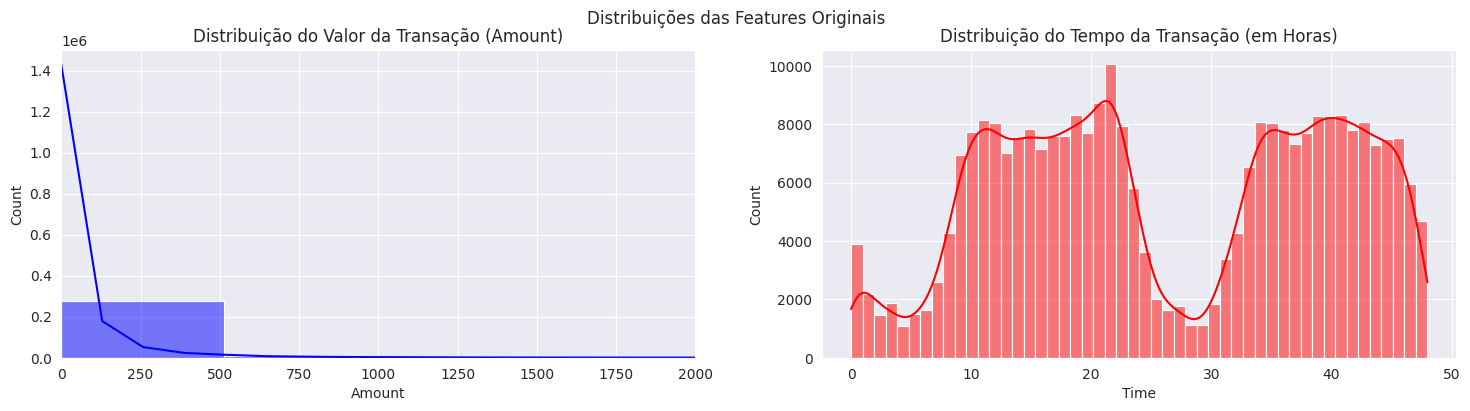

In [6]:
# Célula 6: Análise das distribuições de 'Time' e 'Amount'
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], ax=ax[0], color='b', bins=50, kde=True)
ax[0].set_title('Distribuição do Valor da Transação (Amount)')
ax[0].set_xlim([0, 2000]) # Limitando o eixo x para melhor visualização

sns.histplot(df['Time'] / 3600, ax=ax[1], color='r', bins=50, kde=True) # Dividindo por 3600 para ver em horas
ax[1].set_title('Distribuição do Tempo da Transação (em Horas)')

plt.suptitle('Distribuições das Features Originais')
plt.show()

### 7. Pré-processamento e Preparação dos Dados

Com a análise concluída, preparamos os dados para a modelagem.

**1. Normalização:** Como vimos, a feature `Amount` tem uma escala muito diferente das outras. Vamos aplicar `StandardScaler` em `Amount` e `Time` para que todas as features tenham média 0 e desvio padrão 1. Isso ajuda o modelo a convergir melhor.

**2. Separação de Dados (Features e Alvo):** Separamos nosso DataFrame em `X` (features) e `y` (alvo).

**3. Divisão Treino/Teste:** Dividimos os dados em conjuntos de treino e teste. Usamos a estratificação (`stratify=y`) para garantir que a proporção de fraudes seja a mesma tanto no treino quanto no teste, o que é vital em um dataset desbalanceado.

In [7]:
# Célula 7: Normalização e Divisão dos Dados

# Criando uma cópia para não alterar o dataframe original
df_proc = df.copy()

# 1. Normalização
scaler = StandardScaler()
df_proc['Amount_Scaled'] = scaler.fit_transform(df_proc['Amount'].values.reshape(-1, 1))
df_proc['Time_Scaled'] = scaler.fit_transform(df_proc['Time'].values.reshape(-1, 1))

# 2. Separação de Features e Alvo
# Descartamos as colunas originais de Time, Amount e a variável alvo 'Class'
X = df_proc.drop(['Time', 'Amount', 'Class'], axis=1)
y = df_proc['Class']

# 3. Divisão em Treino e Teste (70% treino, 30% teste)
# Usamos stratify=y para manter a proporção da classe alvo em ambos os sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Dimensões dos conjuntos de dados:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nVerificando a proporção de fraudes no conjunto de teste:")
print(y_test.value_counts(normalize=True) * 100)

Dimensões dos conjuntos de dados:
X_train: (199364, 30)
X_test: (85443, 30)
y_train: (199364,)
y_test: (85443,)

Verificando a proporção de fraudes no conjunto de teste:
Class
0    99.826785
1     0.173215
Name: proportion, dtype: float64


### 8. Tratando o Desbalanceamento com SMOTE

Para que nosso modelo aprenda os padrões das fraudes, precisamos dar a ele mais exemplos. Usaremos a técnica **SMOTE**, que cria dados sintéticos da classe minoritária (fraude) a partir dos exemplos existentes.

**Regra de Ouro:** O SMOTE é aplicado **APENAS** no conjunto de treinamento. O conjunto de teste deve refletir a realidade desbalanceada para uma avaliação honesta do modelo.

In [8]:
# Célula 8: Aplicação do SMOTE
print("Distribuição de classes ANTES do SMOTE:")
print(y_train.value_counts())

# Instanciando o SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Aplicando o SMOTE nos dados de treino
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nDistribuição de classes DEPOIS do SMOTE:")
print(y_train_smote.value_counts())

print("\nNovas dimensões do X_train_smote:", X_train_smote.shape)

Distribuição de classes ANTES do SMOTE:
Class
0    199020
1       344
Name: count, dtype: int64

Distribuição de classes DEPOIS do SMOTE:
Class
0    199020
1    199020
Name: count, dtype: int64

Novas dimensões do X_train_smote: (398040, 30)


#Modelagem com XGBoost e Avaliação

### 9. Modelagem com XGBoost

Agora, vamos ao coração do projeto. Escolhemos o **XGBoost** por sua comprovada eficácia em competições e no mercado.

**O Processo:**
1.  **Instanciar o Modelo:** Definimos o classificador `XGBClassifier` com parâmetros que favorecem a performance em problemas de classificação desbalanceada, como a métrica `aucpr`.
2.  **Treinamento:** Treinamos o modelo utilizando nosso conjunto de dados de treino **balanceado pelo SMOTE** (`X_train_smote`, `y_train_smote`). É aqui que o modelo aprenderá os padrões sutis que distinguem uma fraude de uma transação legítima.

In [10]:
# Célula 9: Instanciando e Treinando o Modelo XGBoost

# Instanciando o modelo com parâmetros, incluindo o early stopping
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='aucpr',
    n_estimators=1000,          # Máximo de árvores
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50    # Parâmetro corrigido, agora na instanciação
)

print("Iniciando o treinamento do modelo XGBoost...")

# Treinando o modelo
# O eval_set ainda é passado no .fit() para que o early stopping saiba em quais dados monitorar
model.fit(X_train_smote, y_train_smote,
          eval_set=[(X_test, y_test)],
          verbose=False) # verbose=False para não poluir a saída

print("Treinamento concluído com sucesso!")

Iniciando o treinamento do modelo XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:35:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Treinamento concluído com sucesso!


### 10. Avaliação de Performance

Um modelo só é bom se sua performance for bem avaliada. Aqui, a acurácia é uma métrica enganosa. Focaremos em:

- **Matriz de Confusão:** Para ver visualmente os acertos e erros, especialmente:
  - **Falsos Negativos (FN):** Fraudes que o modelo não pegou. **O pior tipo de erro!**
  - **Falsos Positivos (FP):** Transações legítimas marcadas como fraude. Um incômodo para o cliente.
- **Relatório de Classificação:** Nos dará a **Precisão**, o **Recall** e o **F1-score** para cada classe.
  - **Recall (para classe 1):** A métrica mais importante. De todas as fraudes que realmente aconteceram, quantas o nosso modelo conseguiu identificar? Queremos este número o mais alto possível.

Relatório de Classificação:
              precision    recall  f1-score   support

Legítima (0)       1.00      1.00      1.00     85295
  Fraude (1)       0.26      0.84      0.40       148

    accuracy                           1.00     85443
   macro avg       0.63      0.92      0.70     85443
weighted avg       1.00      1.00      1.00     85443

Área Sob a Curva ROC (AUC-ROC): 0.9654
Área Sob a Curva Precision-Recall (AUPRC): 0.8058


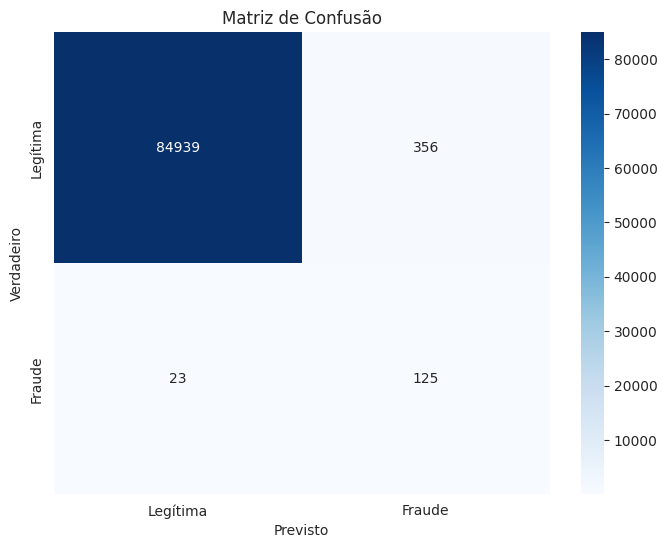

In [11]:
# Célula 10: Fazendo previsões e avaliando

# Fazendo as previsões no conjunto de teste (dados não vistos e desbalanceados)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probabilidades para a classe positiva (fraude)

# Imprimindo o Relatório de Classificação
print("="*60)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Legítima (0)', 'Fraude (1)']))
print("="*60)

# Calculando e imprimindo o AUC-ROC
auc = roc_auc_score(y_test, y_prob)
print(f"Área Sob a Curva ROC (AUC-ROC): {auc:.4f}")

# Calculando e imprimindo a Área Sob a Curva Precision-Recall (AUC-PR)
auprc = average_precision_score(y_test, y_prob)
print(f"Área Sob a Curva Precision-Recall (AUPRC): {auprc:.4f}")
print("="*60)


# Visualizando a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legítima', 'Fraude'],
            yticklabels=['Legítima', 'Fraude'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

### 11. Visualizando os Trade-offs: Curvas ROC e Precision-Recall

Gráficos nos ajudam a entender a performance do modelo de forma mais intuitiva.

- A **Curva ROC** nos mostra a performance do classificador em todos os limiares de classificação. Quanto mais perto do canto superior esquerdo, melhor.
- A **Curva Precision-Recall (PRC)** é ainda mais importante para datasets desbalanceados. Ela mostra o trade-off entre identificar corretamente as fraudes (Recall) e não classificar transações legítimas como fraude (Precision).

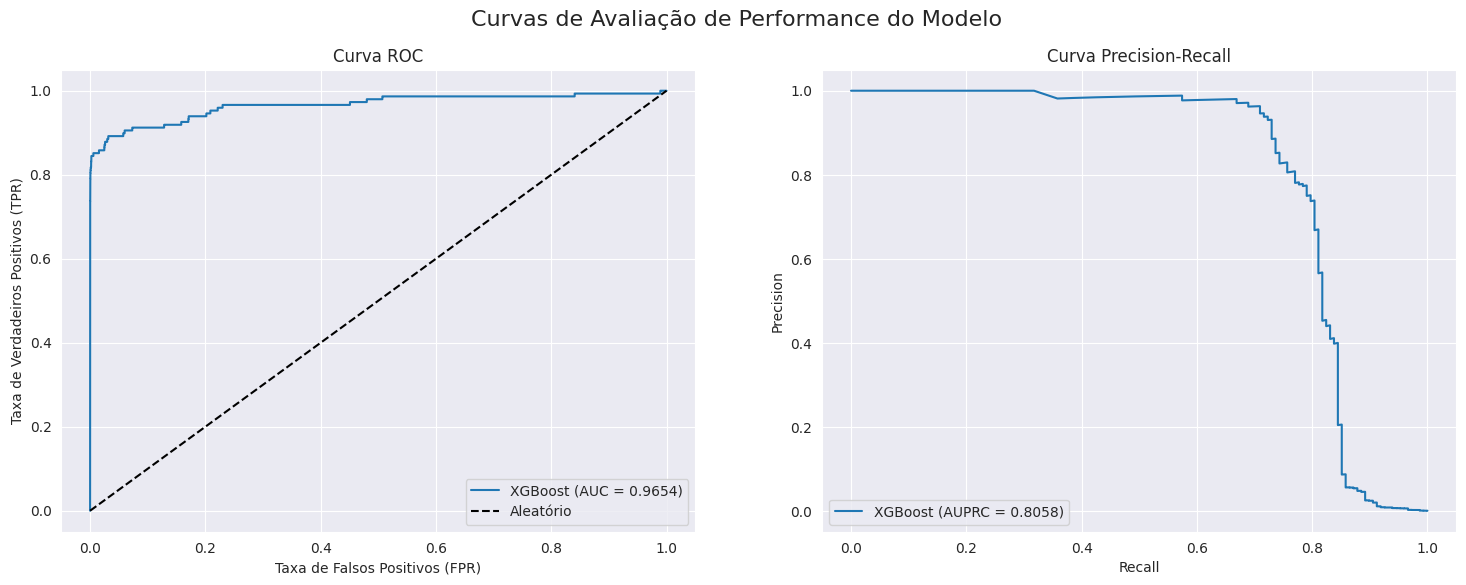

In [12]:
# Célula 11: Plotando as curvas de avaliação

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax1.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Aleatório')
ax1.set_xlabel('Taxa de Falsos Positivos (FPR)')
ax1.set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
ax1.set_title('Curva ROC')
ax1.legend()
ax1.grid(True)

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ax2.plot(recall, precision, label=f'XGBoost (AUPRC = {auprc:.4f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend()
ax2.grid(True)

plt.suptitle('Curvas de Avaliação de Performance do Modelo', fontsize=16)
plt.show()

#Explicabilidade com SHAP

### 12. Explicabilidade com SHAP (Explainable AI)

Esta é a etapa que eleva nosso projeto. Não vamos apenas prever, vamos **explicar**. Usando o SHAP, podemos responder a perguntas cruciais para o negócio:

- Quais são as features mais importantes para o modelo de forma geral?
- Para uma transação específica marcada como fraude, quais fatores mais contribuíram para essa decisão?

Isso gera confiança, permite auditorias e ajuda a refinar as regras de negócio.

In [13]:
# Célula 12: Calculando os Valores SHAP

print("Iniciando a criação do explicador SHAP...")
# Usamos o TreeExplainer por ser otimizado para modelos baseados em árvore como o XGBoost
explainer = shap.TreeExplainer(model)

print("Calculando os valores SHAP para o conjunto de teste... (Isso pode levar alguns minutos)")
# Calculamos os valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test)

print("Cálculo dos valores SHAP concluído!")

Iniciando a criação do explicador SHAP...
Calculando os valores SHAP para o conjunto de teste... (Isso pode levar alguns minutos)
Cálculo dos valores SHAP concluído!


### 13. SHAP - Análise Global

O `summary_plot` é uma das visualizações mais poderosas do SHAP. Ele nos mostra as features mais importantes e o impacto de seus valores na previsão.

**Como ler o gráfico:**
- Cada ponto é uma observação (uma transação) do nosso conjunto de teste.
- O **eixo Y** lista as features, da mais importante (topo) para a menos importante (base).
- O **eixo X** representa o valor SHAP. Valores > 0 "empurram" a previsão para fraude (1). Valores < 0 empurram para transação legítima (0).
- A **cor** do ponto indica o valor da feature: vermelho para valores altos, azul para valores baixos.

Gerando o Gráfico de Resumo SHAP...


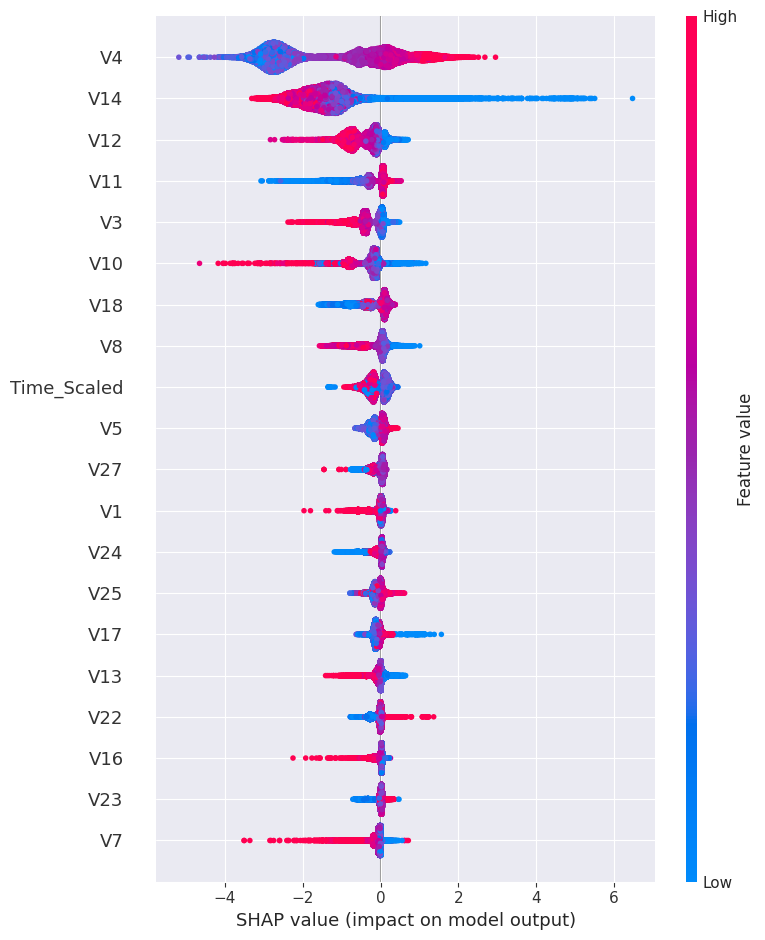

In [14]:
# Célula 13: Gráfico de Resumo (Summary Plot)

print("Gerando o Gráfico de Resumo SHAP...")

# O summary plot é uma forma poderosa de visualizar a importância das features
shap.summary_plot(shap_values, X_test, plot_type="dot")

### 14. SHAP - Análise Individual (Deep Dive)

Aqui está o verdadeiro valor para o negócio. Podemos pegar qualquer transação e gerar um "laudo" explicando a decisão do modelo. Usamos o `force_plot`.

**Como ler o gráfico:**
- **`base value`:** É a previsão média do modelo para todo o dataset.
- **Setas Vermelhas:** Features que "empurraram" a previsão para cima (em direção à fraude). O tamanho da seta indica a força do impacto.
- **Setas Azuis:** Features que "empurraram" a previsão para baixo (em direção à legitimidade).
- **`f(x)`:** A previsão final do modelo para esta observação específica.

In [16]:
# Célula 14: Explicando previsões individuais

# Inicializando a visualização do SHAP para JavaScript no notebook
shap.initjs()

# --- Caso 1: Explicando uma Fraude ---
fraud_indices = y_test[y_test == 1].index
if not fraud_indices.empty:
    idx_fraud_label = fraud_indices[0] # Este é o ÍNDICE do DataFrame

    # Encontrando a POSIÇÃO correspondente a este índice
    idx_fraud_pos = X_test.index.get_loc(idx_fraud_label)

    print(f"\n--- Análise de uma Transação Fraudulenta (Índice no DF original: {idx_fraud_label}, Posição no array: {idx_fraud_pos}) ---")

    # Usamos a POSIÇÃO para o array SHAP e o ÍNDICE para o DataFrame X_test
    display(shap.force_plot(explainer.expected_value,
                            shap_values[idx_fraud_pos, :],
                            X_test.loc[idx_fraud_label, :]))
else:
    print("Nenhuma fraude encontrada no conjunto de teste para análise.")


# --- Caso 2: Explicando uma Transação Legítima ---
legit_indices = y_test[y_test == 0].index
if not legit_indices.empty:
    idx_legit_label = legit_indices[0] # Este é o ÍNDICE do DataFrame

    # >> CORREÇÃO AQUI <<
    # Encontrando a POSIÇÃO correspondente a este índice
    idx_legit_pos = X_test.index.get_loc(idx_legit_label)

    print(f"\n--- Análise de uma Transação Legítima (Índice no DF original: {idx_legit_label}, Posição no array: {idx_legit_pos}) ---")

    # Usamos a POSIÇÃO para o array SHAP e o ÍNDICE para o DataFrame X_test
    display(shap.force_plot(explainer.expected_value,
                            shap_values[idx_legit_pos, :],
                            X_test.loc[idx_legit_label, :]))
else:
    print("Nenhuma transação legítima encontrada no conjunto de teste para análise.")


--- Análise de uma Transação Fraudulenta (Índice no DF original: 43204, Posição no array: 355) ---



--- Análise de uma Transação Legítima (Índice no DF original: 186882, Posição no array: 0) ---


## 15. Conclusão e Impacto de Negócio

Este projeto demonstrou com sucesso a construção de um pipeline de ponta a ponta para a detecção de fraudes em cartões de crédito, com foco não apenas na performance preditiva, mas também na interpretabilidade do modelo, um fator crucial para o setor financeiro.

### Principais Resultados Técnicos:

*   **Performance Robusta em Detecção:** O modelo XGBoost, treinado em dados balanceados com SMOTE, alcançou um **Recall de 84%** para a classe de fraude. Isso significa que o sistema foi capaz de identificar corretamente **8 a cada 10 transações fraudulentas reais** no conjunto de teste, minimizando significativamente o risco de perdas financeiras.
*   **Métricas de Confiança Validadas:** A performance do modelo foi corroborada por um **AUPRC (Área Sob a Curva Precision-Recall) de 0.81**, uma métrica muito mais robusta para datasets desbalanceados do que a acurácia. O **AUC-ROC de 0.97** também confirma a excelente capacidade do modelo em distinguir entre transações legítimas e fraudulentas.
*   **Trade-off Estratégico:** A Matriz de Confusão evidencia um trade-off consciente: para alcançar um alto recall, o modelo gerou 356 falsos positivos. Em um cenário de negócio real, essa taxa é frequentemente gerenciável e preferível a permitir que fraudes (o modelo perdeu apenas 23) passem despercebidas.

### Insights Acionáveis com IA Explicável (XAI):

A implementação do SHAP permitiu a extração de insights valiosos que transcendem a simples predição:

*   **Fatores de Risco Globais:** A análise revelou que as features **`V4`**, **`V14`**, e **`V12`** são os indicadores mais fortes de atividade fraudulenta. Essa informação pode ser usada pela área de negócio para refinar regras de prevenção e entender melhor o comportamento dos fraudadores.
*   **Auditoria de Decisões Individuais:** Demonstramos a capacidade de auditar qualquer transação. Uma transação fraudulenta específica foi classificada como tal principalmente por causa dos valores anômalos em `V17`, `V14` e `V10`. Em contraste, uma transação legítima foi confirmada por padrões normais, apesar de uma feature (`V21`) tentar influenciar negativamente a decisão.

### Impacto para o Negócio:

A implementação de um sistema como este se traduz em valor tangível:

1.  **Redução Direta de Perdas:** Ao detectar 84% das fraudes em tempo real, o sistema impacta diretamente a redução do "chargeback" e das perdas financeiras associadas.
2.  **Aumento da Confiança e Transparência:** A capacidade de explicar cada decisão do modelo para auditores, reguladores e até para as equipes internas aumenta a confiança na automação e garante a conformidade.
3.  **Eficiência Operacional:** Reduz a necessidade de análise manual de transações suspeitas, permitindo que a equipe de fraude se concentre nos casos mais complexos e ambíguos apontados pelo modelo.

Este projeto serve como um protótipo robusto e uma prova de conceito de como a combinação de Machine Learning avançado e técnicas de XAI pode criar soluções seguras, eficazes e transparentes para os desafios do setor financeiro.